<a href="https://colab.research.google.com/github/cristyfarrufia/Clase_Sem04/blob/main/08-05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalar la libreria kaggle API 
!pip install -q kaggle
#Instalar la libreria MONAI usando pip
!pip install monai

In [ ]:
#creando un directorio para el token API de kaggle
!mkdir -p ~/.kaggle

#Cargando el token de la API de kaggle
#Aquí está cómo obtener el token...
from google.colab import files
files.upload()


In [ ]:
#Copiar el token de la API de kaggle en el directorio creado
!cp kaggle.json ~/.kaggle/

#Descargando el conjunto de datos de kaggle
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

#Descomprimir el conjunto de datos descargado
!unzip /content/finding-lungs-in-ct-data.zip

#establecer la ruta para los volúmenes de imágenes 3D
data_dir = '/content/3d_images'

In [ ]:
#Importa el módulo 'os' para funciones relacionadas con el sistema operativo
import os
#Importa el módulo 'glob' para funciones relacionadas con el sistema operativo
import glob
#Importa el módulo 'torch' para funciones relacionadas con el sistema operativo
import torch
#Importa el módulo 'numpy' para funciones relacionadas con el sistema operativo
import numpy as np
#Importa el módulo 'nibabel' para funciones relacionadas con el sistema operativo
import nibabel as nib
#Importa el módulo 'matplotlib.pyplot' para funciones relacionadas con el sistema operativo
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
data_dir = '/content/3d_images'
#obtiene una lista de rutas de archivos de imagen usando glob
images = sorted(glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
#obtiene una lista de rutas de archivos de etiquetas usando glob
labels = sorted(glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))
#imprime el número de imágenes y etiquetas encontradas
print('No. of images:', len(images), 'labels:', len(labels))



In [ ]:
#cargar e inspeccionar la primera imagen y etiqueta
#carga los datos de la imagen usando nibabel y obtenga la matriz de datos de la imagen
img = nib.load(images[0]).get_fdata()

In [ ]:
#carga los datos de la etiqueta usando nibabel y obtenga la matriz de datos de la etiqueta
lbl = nib.load(labels[0]).get_fdata()

In [ ]:
#imprime la forma de la imagen cargada y las matrices de etiquetas
print('\nimg shape:', img.shape, 'lbl shape:', lbl.shape)

In [ ]:
#imprime los valores de intensidad mínima y máxima de los datos de la imagen y las etiquetas únicas en los datos de la etiqueta
print('img intensity min.:', np.min(img), 'max.:', np.max(img), 'unique labels:', np.unique(lbl))

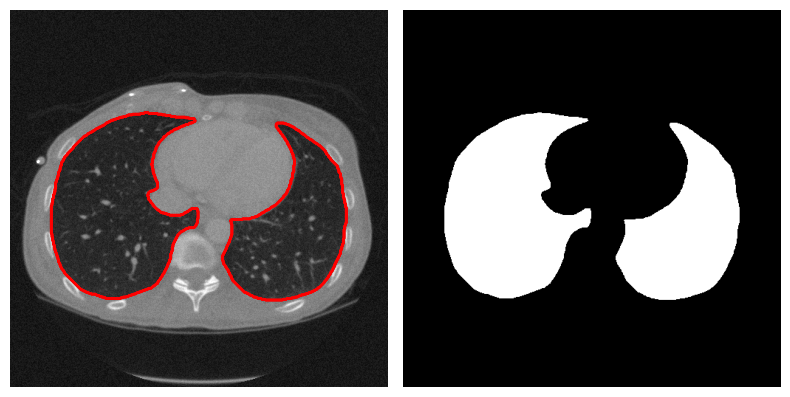

In [ ]:
#define el índice de corte para la visualización
slice_idx = 82
#cree una subparcela con dos subparcelas para mostrar la imagen y la etiqueta
#crea una figura con un tamaño de 8x5 pulgadas
plt.figure(figsize=(8,5))
#crea la primera subparcela para mostrar la imagen
plt.subplot(1,2,1)
#se muestra la imagen usando la función 'imshow' de matplotlib, con un mapa de colores en escala de grises y establezca el rango de intensidad entre -1000 y 1000
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
#se superpone el contorno de la etiqueta en la parte superior de la imagen usando la función 'contorno' de matplotlib, con color rojo
plt.contour(lbl[slice_idx], colors='red')
#apaga el eje para la primera subtrama
plt.axis('off')
#crea la segunda subtrama para mostrar la etiqueta
plt.subplot(1,2,2)
#muestra la etiqueta usando la función 'imshow' de matplotlib, con un mapa de colores en escala de grises
plt.imshow(lbl[slice_idx], cmap='gray')
#apaga el eje para la segunda subparcela
plt.axis('off')
#ajusta el diseño de las subparcelas para un mejor espaciado
plt.tight_layout()
#muestra la trama
plt.show()


In [ ]:
from monai.utils import first, set_determinism

set_determinism(seed=42)

In [ ]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]

train_files, val_files, test_files = data_dicts[:2], data_dicts[2:3], data_dicts[-1:]

print('train files:', len(train_files), 'val files:', len(val_files), 'test files:', len(test_files))

train files: 2 val files: 1 test files: 1


In [ ]:

from monai.transforms.intensity.dictionary import RandScaleIntensityD
from monai.transforms.croppad.dictionary import RandSpatialCropD
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invert,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

train_transforms = Compose (
    [
        LoadImaged(keys=["image", "label"]),
     
     EnsureChannelFirstd(keys=["images", "label"]),

     ScaleIntensityRanged(
         keys=["image"], a_min=-1000, a_max=1000,
         b_min=0.0, b_max=1.0, clip=True,
     ),

     ScaleIntensityRanged(
         keys=["label"], a_min=0, a_max=255,
         b_min=0.0, b_max=1.0, clip=True,

     ),

     CropForegroundd(keys=["images", "label"], source_key="image"),

     Orientationd(keys=["images", "label"], axcodes="PLS"),
#vuelve a muestrear el espaciado de la imagen y la etiqueta a las dimensiones de píxeles especificadas mediante interpolación bilineal
     Spacingd(keys=["images", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#recorta aleatoriamente un parche de los archivos de imagen y etiqueta
     RandSpatialCropd (
         keys=["image", "label"],
         roi_size=[96, 96, 96],
         random_size=False,
     ),
#aplica una transformación afín aleatoria tanto a la imagen como a la etiqueta con parámetros específicos
     RandAffined(
         keys=["image", "label"],
         mode=('bilinear', 'nearest'),
         prob=1.0, spatial_size(96, 96, 96),
         rotate_range=(0, 0, np.pi/15),
         scale_range=(0.1, 0.1, 0.1)),
#voltea aleatoriamente la imagen y la etiqueta a lo largo del eje espacial 0 con una probabilidad de 0.25
     RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
#voltea aleatoriamente la imagen y la etiqueta a lo largo del eje espacial 1 con una probabilidad de 0.25
     RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
#voltea aleatoriamente la imagen y la etiqueta a lo largo del eje espacial 2 con una probabilidad de 0.25
     RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
#escala aleatoriamente la intensidad de la imagen con un factor de 0,1 con una probabilidad de 1,0
     RandScaleIntensityd(keys="images", factors=0.1, prob=1.0),
#cambia aleatoriamente la intensidad de la imagen con un desplazamiento de 0,1 con una probabilidad de 1,0
     RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

    ])

In [ ]:
val_transforms = Compose([  #define una composición de transformaciones de aumento de datos
    LoadImaged(keys=["image", "label"]), #carga imágenes y etiquetas usando teclas específicas
    EnsureChannelFirstd(keys=["image", "label"]), #asegura que el canal sea la primera dimensión para imágenes y etiquetas
    ScaleIntensityRanged(  #escala los valores de intensidad de las imágenes a un rango específico
        keys=["image"], a_min=-1000, a_max=1000, #establece el rango de intensidad de entrada para las imágenes
        b_min=0.0, b_max=1.0, clip=True, #establece el rango de intensidad de salida para imágenes y valores de clip fuera del rango
    ),
    ScaleIntensityRanged(  #escala los valores de intensidad de las etiquetas al rango especificado
        keys=["label"], a_min=0, a_max=255, #establece el rango de intensidad de entrada para las etiquetas
        b_min=0.0, b_max=1.0, clip=True, #establece el rango de intensidad de salida para etiquetas y valores de clip fuera del rango
    ),
    CropForegroundd(keys=["image", "label"], source_key="iamge"), #recorta la región de primer plano de imágenes y etiquetas usando la imagen como referencia
    Orientationd(keys=["image", "label"], axcodes="PLUS"), #aplica normalización de orientación a imágenes y etiquetas usando códigos de ejes específico
    Spacingd(keys["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")), #vuelve a muestrear imágenes y etiquetas al espaciado de vóxel especificado
])

In [ ]:
sample_ds = Dataset(data=train_files, transform=train_transforms) #crea una instancia del objeto Dataset (conjunto de datos) para el entrenamiento de un modelo de aprendizaje automático. #Queremos que la línea de código cree una instancia del objeto Dataset para entrenamiento de un modelo de aprendizaje automático porque el objeto Dataset se utiliza para cargar y preprocesar los datos antes de que se utilicen para entrenar el modelo.#Al cambiar el parámetro data, se cambiará el conjunto de datos de entrenamiento utilizado para entrenar el modelo.
sample_dataloader = DataLoader(sample_ds, batch_size=1) #crea un objeto DataLoader en PyTorch, que es utilizado para cargar datos de un conjunto de datos llamado "sample_ds". #Queremos que la línea de código cree un DataLoader para el conjunto de datos "sample_ds" porque el DataLoader es una herramienta útil para dividir un conjunto de datos en lotes, lo que permite un procesamiento más eficiente y una mejor utilización de la memoria de la computadora. #Al cambiar el parámetro "batch_size" se afecta el tamaño de los lotes de datos que se cargan en cada iteración del bucle de entrenamiento.
sample_batch = first(sample_dataloader) #carga el primer lote de datos del objeto DataLoader llamado "sample_dataloader" en la variable "sample_batch". #

img, lbl = sample_batch["image"][0][1], sample_batch["label"][0][1]
print(f"img shape: {img.shape}, lbl shape: {lbl.shape}")

slice_idx = 42
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,slice_idx], cmap='gray')
plt.contour(lbl[:,:,slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[:,:,slice_idx],cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()